# Bayesian black-box model-predictive control

An Expected Free Energy minimizing agent based on a nonlinear autoregressive model with exogenous input.

## System: driven damped pendulum

Consider a single pendulum with angle $\theta(t)$ and input $u(t)$ evolving according to:

$$ \ddot{\theta} + \frac{\mathcal{g}}{l} \sin(\theta) + \frac{\gamma}{l} \dot{\theta} = \frac{1}{ml} u\, .$$

where $m$ is mass, $l$ is length, $\gamma$ is damping and $\mathcal{g}$ is Earth's gravity.

In [1]:
using Revise
using ForwardDiff
using Optim
using RxInfer
using SpecialFunctions
using LinearAlgebra
using ProgressMeter
using Distributions
using Plots; default(grid=false, label="", linewidth=3,margin=20Plots.pt)

includet("../NARXAgents.jl"); using .NARXAgents
includet("./Pendulums.jl"); using .Pendulums

In [2]:
# System parameters
sys_mass = 1.0
sys_length = 2.0
sys_damping = 0.1
sys_tqlims = (-3., 3.)
sys_mnoise_sd = 0.001
Δt = 0.2

0.2

In [3]:
init_state = [0.0, 0.0]
pendulum = SPendulum(init_state = init_state, 
                     torque_lims = sys_tqlims,
                     mass = sys_mass, 
                     length = sys_length, 
                     damping = sys_damping, 
                     mnoise_sd = sys_mnoise_sd, 
                     Δt=Δt)

SPendulum([0.0, 0.0], 0.000378063862449625, 0.0, (-3.0, 3.0), 0.2, 1.0, 2.0, 0.1, 0.001)

### Test system

In [4]:
N = 600
tsteps = range(0.0, step=Δt, length=N)

0.0:0.2:119.8

In [5]:
# Inputs
A  = rand(10)*200 .- 100
Ω  = rand(10)*3
controls = mean([A[i]*sin.(Ω[i].*tsteps) for i = 1:10])./30;

In [6]:
states = zeros(2,N)
observations = zeros(N)
torques = zeros(N)

for k in 1:N
    states[:,k] = pendulum.state
    observations[k] = pendulum.sensor
    step!(pendulum, controls[k])
    torques[k] = pendulum.torque
end

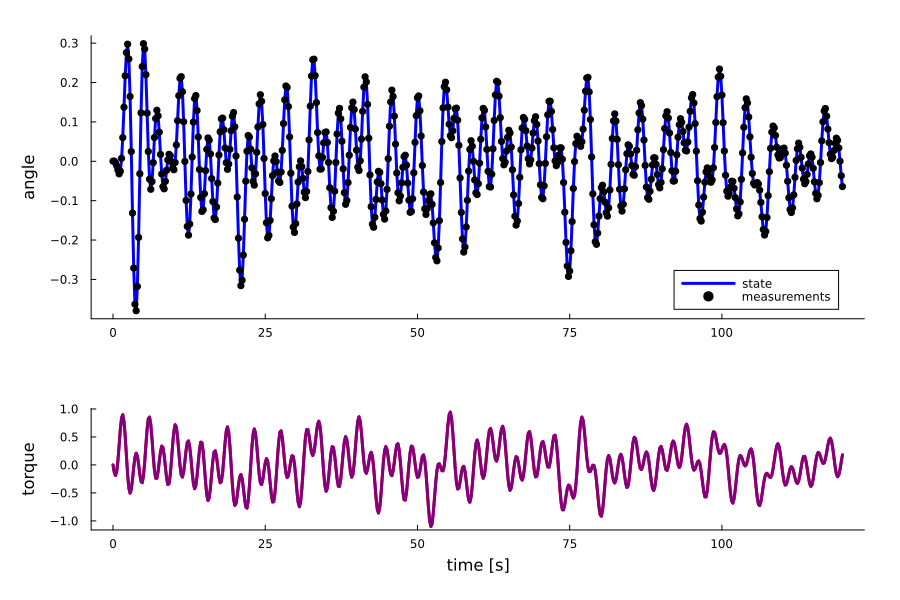

In [7]:
p1 = plot(ylabel="angle")
plot!(tsteps, states[1,:], color="blue", label="state")
scatter!(tsteps, observations, color="black", label="measurements")
p2 = plot(xlabel="time [s]", ylabel="torque")
plot!(tsteps, controls[:], color="red")
plot!(tsteps, torques[:], color="purple")
plot(p1,p2, layout=grid(2,1, heights=[0.7, 0.3]), size=(900,600))

## Parameter estimation

In [8]:
# NARX settings
H = 3
Ly = 3
Lu = 3
M = size(ϕ(zeros(1 + Ly+Lu), degree=H),1);

# Specify prior distributions
pτ0 = GammaShapeRate(1e2, 1e0)
pθ0 = MvNormalMeanCovariance(randn(M)./100, diagm(ones(M)))
goal = NormalMeanVariance(3.14, 1e-3)

T = 10
u_prior = 0.0
num_iters = 5

agent = NARXAgent(pθ0, pτ0, 
                  goal_prior=goal, 
                  delay_in=Lu, 
                  delay_out=Ly, 
                  pol_degree=H,
                  thorizon=T,
                  control_prior=u_prior,
                  num_iters=num_iters)

NARXAgent(FactorGraphModel(), Constraints:
  marginals form:
  messages form:
  factorisation:
    q(θ, τ) = q(θ)q(τ)
Options:
  warn = true
, [Inf], MvNormalMeanCovariance(
μ: [-0.002317512074600191, -0.014431728145332836, -0.006487069771092893, 0.010155205989920287, 0.010671044099538958, -0.012217187251562994, 0.016066777663790454, -0.0034520338491832786, -0.01957798342137427, -0.02320213049652218  …  -0.001340568275413864, 0.009797761477312808, 0.010418882031961925, 0.007841100893564944, -0.010008832765355575, -0.0007482992565600505, -0.008133387292357009, 0.011589165250956488, -0.008856087025236228, 0.004874738861781082]
Σ: [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0]
)
, GammaShapeRate{Float64}(a=100.0, b=1.0), NormalMeanVariance{Float64}(μ=3.14, v=0.001), 10, 5, 0.0, 3, 3, 3, 22, [0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0])

In [9]:
py = []
qθ = [pθ0]
qτ = [pτ0]
FE = zeros(num_iters,N)

@showprogress for k in 1:(N-T)
    
    # Make predictions
    push!(py, predictions(agent, controls[k:k+T], time_horizon=T))
    
    # Update beliefs
    NARXAgents.update!(agent, observations[k], controls[k])
    push!(qθ, agent.qθ)
    push!(qτ, agent.qτ)
    
    # Evaluate
    FE[:,k] = agent.free_energy
end

Progress:   0%|▏                                        |  ETA: 1:06:17

Progress: 100%|█████████████████████████████████████████| Time: 0:00:15


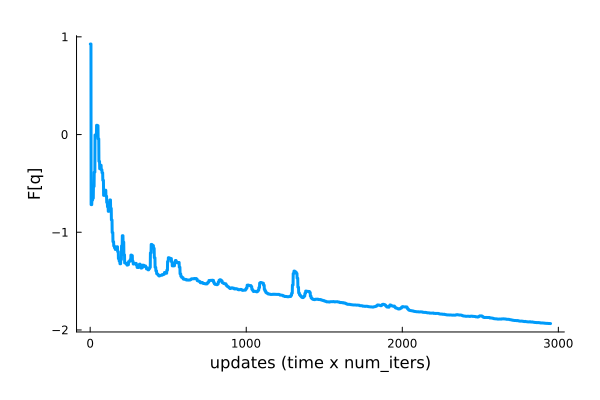

In [10]:
plot(reshape(FE[:,1:(N-T)], (num_iters*(N-T),)), xlabel="updates (time x num_iters)", ylabel="F[q]")

In [11]:
vθ = cat( var.(qθ)...,dims=2)
mθ = cat(mean.(qθ)...,dims=2)

22×591 Matrix{Float64}:
 -0.00231751    0.000351376   0.000838651  …   7.02103e-6    6.98252e-7
 -0.0144317    -0.0144317    -0.0144131        1.0794        1.07927
 -0.00648707   -0.00648707   -0.00648707       0.245293      0.245509
  0.0101552     0.0101552     0.0101552       -0.647071     -0.647262
  0.010671      0.010671      0.00415719       0.020131      0.0200714
 -0.0122172    -0.0122172    -0.0122172    …  -0.0259834    -0.0258918
  0.0160668     0.0160668     0.0160668        0.067784      0.0676896
 -0.00345203   -0.00345203   -0.00345203       0.00479922    0.00481598
 -0.019578     -0.019578     -0.019578        -0.00120178   -0.00106096
 -0.0232021    -0.0232021    -0.0232021        0.000736854   0.000883464
  ⋮                                        ⋱                 ⋮
  0.00979776    0.00979776    0.00979776      -0.000941907  -0.000864143
  0.0104189     0.0104189     0.0104189        0.000417926   0.000401547
  0.0078411     0.0078411     0.0078411    …   0.0418221

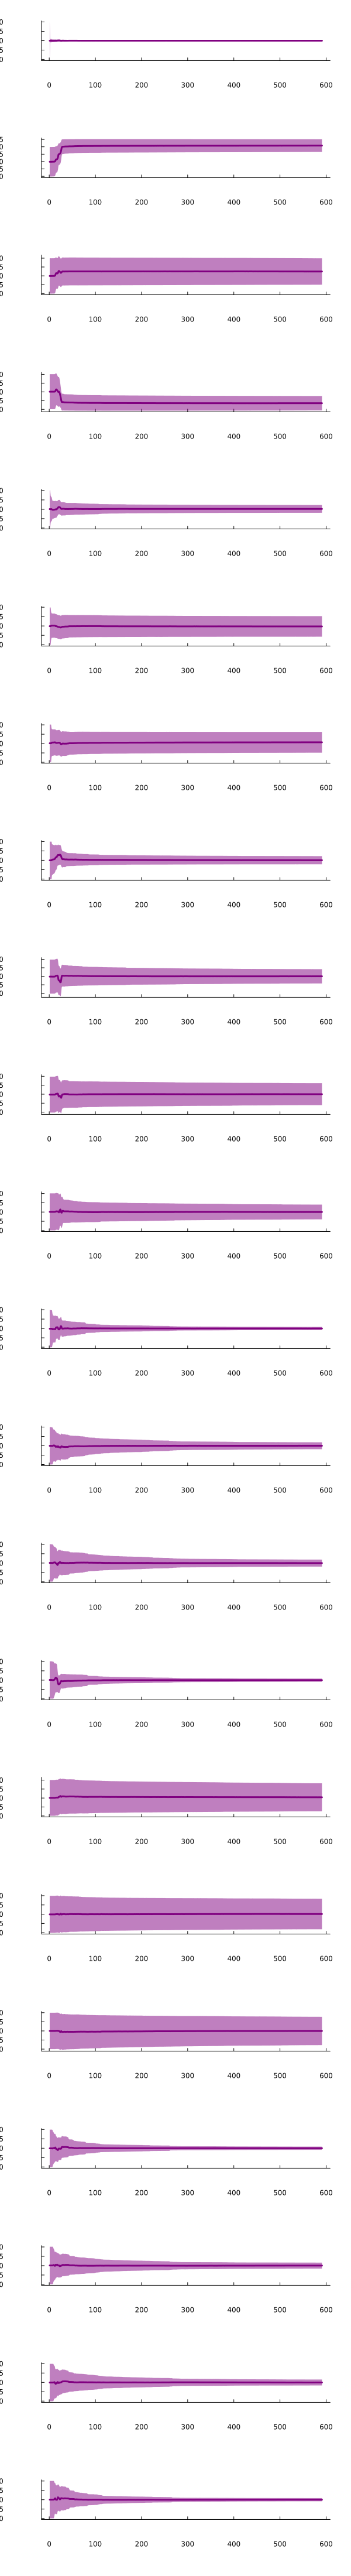

In [12]:
pw = []
for m in 1:M
    pwm = plot()
    plot!(mθ[m,:], ribbon=sqrt.(vθ[m,:]), color="purple", ylabel="θ_$m")
    push!(pw,pwm)
end
plot(pw..., layout=(M,1), size=(600,M*200))

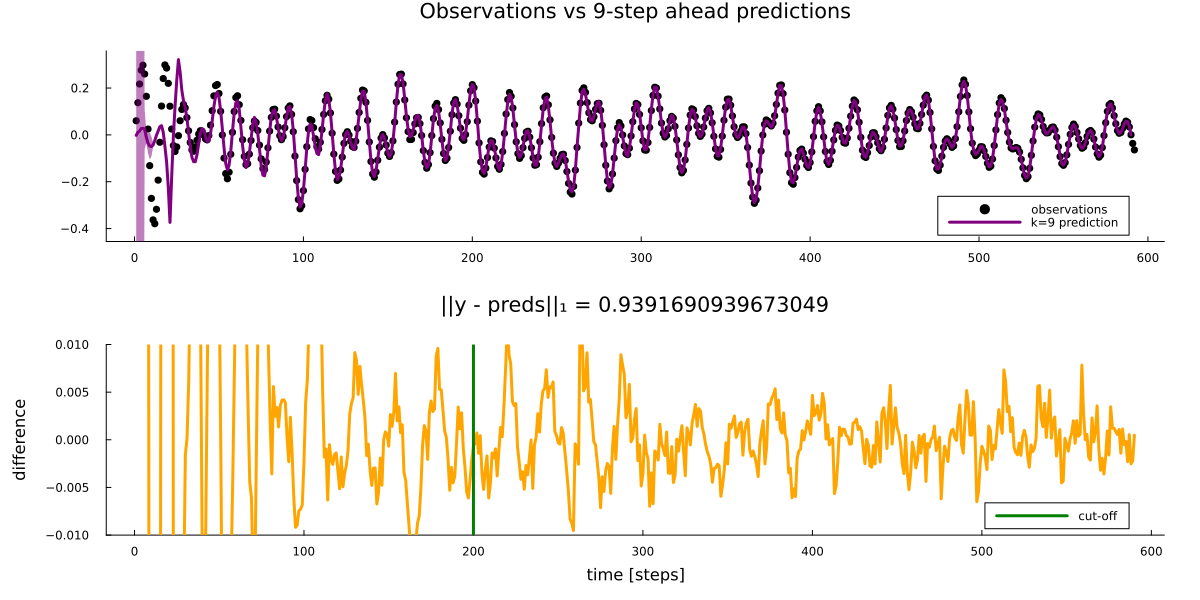

In [13]:
limsb = [minimum(observations)*1.2, maximum(observations)*1.2]
K = 9

residuals = observations[K:K+(N-T)-1] .- [mean(py[k][K]) for k in 1:(N-T)]
cutoff = 200
SAE = sum(abs.(residuals[cutoff:end]))

p1 = plot(title="Observations vs $K-step ahead predictions", ylims=limsb)
scatter!(observations[K:end], color="black", label="observations")
plot!([mean(py[k][K]) for k in 1:(N-T)], ribbon=[var(py[k][K]) for k in 1:(N-T)], color="purple", label="k=$K prediction")
p2 = plot(xlabel="time [steps]", ylims=[-.01, .01])
plot!(residuals, title="||y - preds||₁ = $SAE", color="orange", ylabel="difference")
vline!([cutoff], color="green", label="cut-off")
plot(p1,p2,layout=grid(2,1), size=(1200,600),)

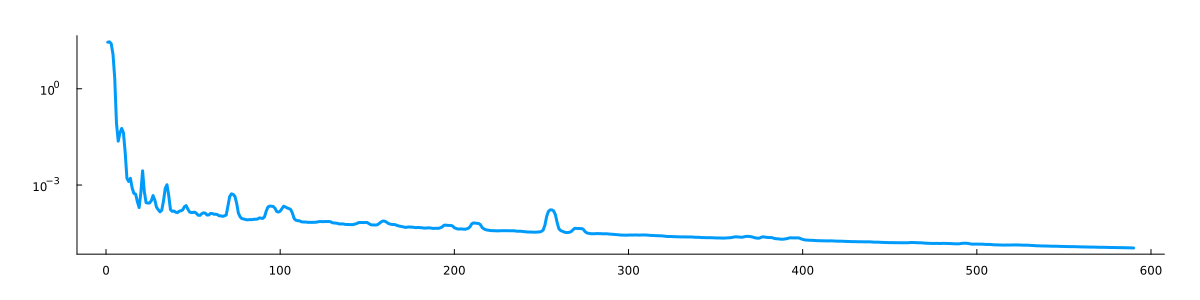

In [14]:
plot([var(py[k][K]) for k in 1:(N-T)], size=(1200,300), yscale=:log10)

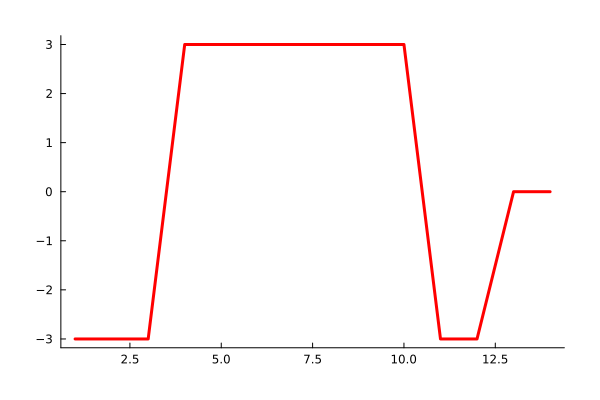

In [15]:
# policy = 3 .*ones(15)
opt_policy = [-3*ones(3); 3*ones(7); -3*ones(2); zeros(2)]
plot(opt_policy, color="red")

In [16]:
pendulum.state = [0.0, 0.]
sys_trajectory = sim_trajectory(pendulum, opt_policy)

2×14 Matrix{Float64}:
  0.0  -0.12   -0.3552   -0.677504  …  2.94124   3.06927   3.15313
 -0.6  -1.176  -1.61152  -0.605891     0.640132  0.419295  0.331635

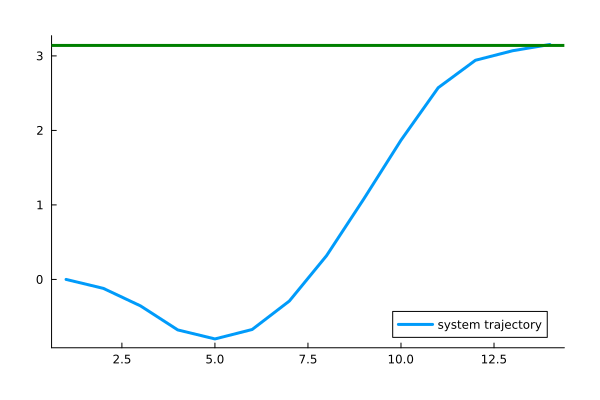

In [17]:
plot(sys_trajectory[1,:], label="system trajectory")
hline!([mean(goal)], color="green")

## Experiments

In [18]:
# Length of trial
N = 50
tsteps = range(0.0, step=Δt, length=N)
T = 14

# Set control properties
goal = NormalMeanVariance(3.14, 1e-3)
control_prior = 0.0
num_iters = 4
u_lims = (-3., 3.)
tlimit = 10

# Polynomial degree
H = 3

# Delay order
Ly = 3
Lu = 3

# Model order
M = size(ϕ(zeros(1+Ly+Lu), degree=H),1);

# Specify prior distributions
pτ0 = GammaShapeRate(1e2, 1e0)
pθ0 = MvNormalMeanCovariance(randn(M)./100, diagm(ones(M)))

init_state = [0.0, 0.0];

### Expected Free Energy minimization

In [19]:
policy = zeros(T)

14-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [20]:
pendulum = SPendulum(init_state = [0.0, 0.0], 
                     torque_lims = u_lims,
                     mass = sys_mass, 
                     length = sys_length, 
                     damping = sys_damping, 
                     mnoise_sd = sys_mnoise_sd, 
                     Δt=Δt)

agent = NARXAgent(qθ[end], qτ[end], 
                  goal_prior=goal, 
                  delay_in=Lu, 
                  delay_out=Ly, 
                  pol_degree=H,
                  thorizon=T,
                  control_prior=0.0,
                  num_iters=5)

# agent.ybuffer = -2*ones(Ly)
agent.ybuffer = zeros(Ly)
# agent.ubuffer = -3*ones(Lu+1)
agent.ubuffer = zeros(Lu+1)

function obj_tmp(agent::NARXAgent, controls)
    "Expected Free Energy"

    μ = mean( agent.qθ)
    Σ = cov(  agent.qθ)
    α = shape(agent.qτ)
    β = rate( agent.qτ)

    ybuffer = agent.ybuffer
    ubuffer = agent.ubuffer
    
    # J = 0
    m_y = 0.0
    v_y = 0.0
    for t in 1:agent.thorizon
        
        # Update control buffer
        ubuffer = NARXAgents.backshift(ubuffer, controls[t])
        ϕ_k = ϕ([ybuffer; ubuffer], degree=agent.pol_degree)
        
        # Prediction
        m_y = dot(μ, ϕ_k)
        # v_y = (ϕ_k'*Σ*ϕ_k + 1)*β/α
        v_y = ϕ_k'*Σ*ϕ_k + β/α

        # J += NARXAgents.risk(agent, Normal(m_y,v_y))
        
        # Update previous 
        ybuffer = NARXAgents.backshift(ybuffer, m_y)        
    end
    J = NARXAgents.risk(agent, Normal(m_y,v_y))
    
    return J
end

opts = Optim.Options(time_limit=300, 
                    #  show_trace=true, 
                     allow_f_increases=true, 
                     g_tol=1e-12, 
                     show_every=10,
                     iterations=10_000)

# Objective function
J(u) = obj_tmp(agent, u)

# Constrained minimization procedure
results = optimize(J, u_lims..., policy, Fminbox(LBFGS()), opts, autodiff=:forward)

ErrorException: type NARXAgent has no field goal

In [21]:
policy = Optim.minimizer(results)
plot(policy)

UndefVarError: UndefVarError: `results` not defined

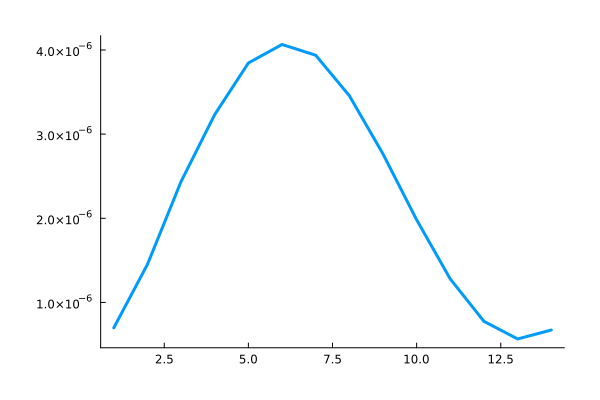

In [22]:
plot(mean.(predictions(agent, policy, time_horizon=T)))

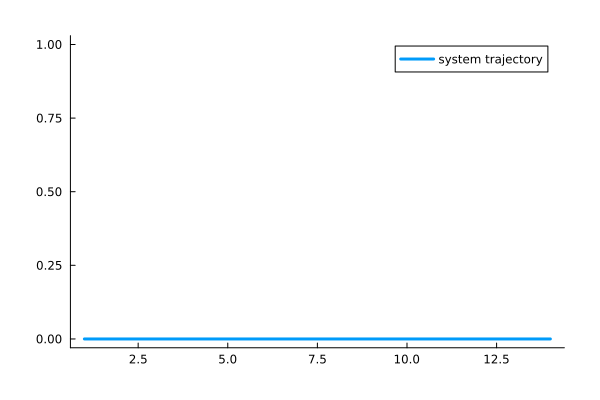

In [23]:
pendulum.state = [0.0, 0.]
sys_trajectory = sim_trajectory(pendulum, policy)
plot(sys_trajectory[1,:], label="system trajectory")

In [24]:
# Start system
pendulum = SPendulum(init_state = [0.0, 0.0], 
                     torque_lims = u_lims,
                     mass = sys_mass, 
                     length = sys_length, 
                     damping = sys_damping, 
                     mnoise_sd = sys_mnoise_sd, 
                     Δt=Δt)

# Track beliefs
py_EFE = []
pτ_EFE = [pτ0]
pθ_EFE = [pθ0]
goals = Any[false for t in 1:T]

# Start agent
agent = NARXAgent(qθ[end], qτ[end], 
                  goal_prior=goals, 
                  delay_in=Lu, 
                  delay_out=Ly, 
                  pol_degree=H,
                  thorizon=T,
                  num_iters=num_iters)

# Preallocate
y_EFE = zeros(N)
u_EFE = zeros(N+T)
FE_EFE = zeros(num_iters, N)
policy = zeros(T)

@showprogress for k in 1:N
    
    # Act upon environment
    step!(pendulum, u_EFE[k])
    y_EFE[k] = pendulum.sensor

    """Perception"""
    
    # Update parameter beliefs
    NARXAgents.update!(agent, y_EFE[k], u_EFE[k])
    FE_EFE[:,k] = agent.free_energy
    push!(pθ_EFE, agent.qθ)
    push!(pτ_EFE, agent.qτ)

    """Action"""

    # Move goal closer
    update_goals!(goals, goal)
    agent.goals = goals

    # Optimal control
    policy = minimizeEFE(agent, goals, time_limit=tlimit, control_lims=u_lims)
    # policy = minimizeEFE(agent, goals, u_0=policy, time_limit=tlimit, control_lims=u_lims)
    u_EFE[k+1:k+T] = policy

    # Store future predictions
    push!(py_EFE, predictions(agent, policy, time_horizon=T))
end

Progress:   4%|█▋                                       |  ETA: 0:02:33

Progress:   6%|██▌                                      |  ETA: 0:02:00

Progress:   8%|███▎                                     |  ETA: 0:01:46

Progress:  10%|████▏                                    |  ETA: 0:01:28

Progress:  12%|████▉                                    |  ETA: 0:01:33

Progress:  14%|█████▊                                   |  ETA: 0:01:30

Progress:  16%|██████▌                                  |  ETA: 0:01:29

Progress:  18%|███████▍                                 |  ETA: 0:01:27

Progress:  20%|████████▎                                |  ETA: 0:01:25

Progress:  22%|█████████                                |  ETA: 0:01:28

Progress:  24%|█████████▉                               |  ETA: 0:01:21

Progress:  26%|██████████▋                              |  ETA: 0:01:23

Progress:  28%|███████████▌                             |  ETA: 0:01:20

Progress:  30%|████████████▎                            |  ETA: 0:01:28

Progress:  32%|█████████████▏                           |  ETA: 0:01:33

Progress:  34%|██████████████                           |  ETA: 0:01:34

Progress:  36%|██████████████▊                          |  ETA: 0:01:32

Progress:  38%|███████████████▋                         |  ETA: 0:01:35

Progress:  40%|████████████████▍                        |  ETA: 0:01:39

Progress:  42%|█████████████████▎                       |  ETA: 0:01:40

Progress:  44%|██████████████████                       |  ETA: 0:01:42

Progress:  46%|██████████████████▉                      |  ETA: 0:01:41

Progress:  48%|███████████████████▋                     |  ETA: 0:01:42

Progress:  50%|████████████████████▌                    |  ETA: 0:01:44

Progress:  52%|█████████████████████▍                   |  ETA: 0:01:37

Progress:  54%|██████████████████████▏                  |  ETA: 0:01:30

Progress:  56%|███████████████████████                  |  ETA: 0:01:25

Progress:  58%|███████████████████████▊                 |  ETA: 0:01:19

Progress:  60%|████████████████████████▋                |  ETA: 0:01:14

Progress:  62%|█████████████████████████▍               |  ETA: 0:01:08

Progress:  64%|██████████████████████████▎              |  ETA: 0:01:03

Progress:  66%|███████████████████████████              |  ETA: 0:00:58

Progress:  68%|███████████████████████████▉             |  ETA: 0:00:53

Progress:  70%|████████████████████████████▊            |  ETA: 0:00:49

Progress:  72%|█████████████████████████████▌           |  ETA: 0:00:44

Progress:  74%|██████████████████████████████▍          |  ETA: 0:00:41

Progress:  76%|███████████████████████████████▏         |  ETA: 0:00:37

Progress:  78%|████████████████████████████████         |  ETA: 0:00:33

Progress:  80%|████████████████████████████████▊        |  ETA: 0:00:30

Progress:  82%|█████████████████████████████████▋       |  ETA: 0:00:27

Progress:  84%|██████████████████████████████████▌      |  ETA: 0:00:25

Progress:  86%|███████████████████████████████████▎     |  ETA: 0:00:21

Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:18

Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:15

Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:12

Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:09

Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:06

Progress:  98%|████████████████████████████████████████▏|  ETA: 0:00:03

Progress: 100%|█████████████████████████████████████████| Time: 0:02:27


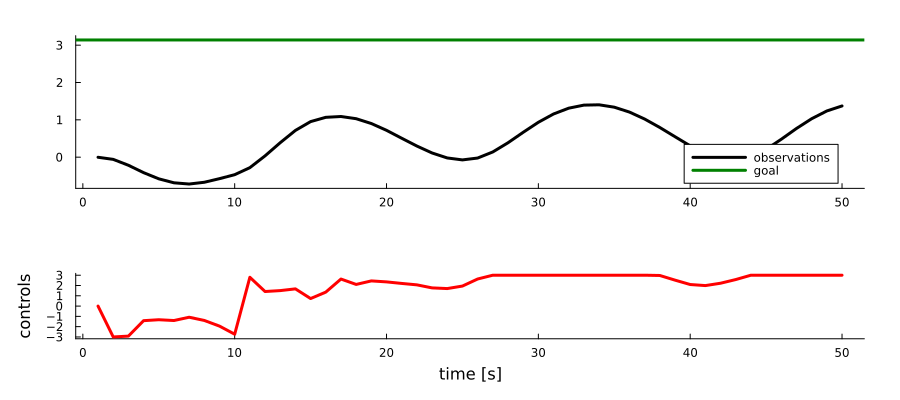

In [25]:
p1 = plot(y_EFE, color="black", label="observations")
hline!([mean(goal)], color="green", label="goal")
p4 = plot(u_EFE[1:end-T], color="red", ylabel="controls", xlabel="time [s]")

plot(p1,p4, layout=grid(2,1, heights=[.7, .3]), size=(900,400))

In [26]:
savefig("figures/NARX-EFE-1Pendulum-trial.png")

"/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/pendulum/figures/NARX-EFE-1Pendulum-trial.png"

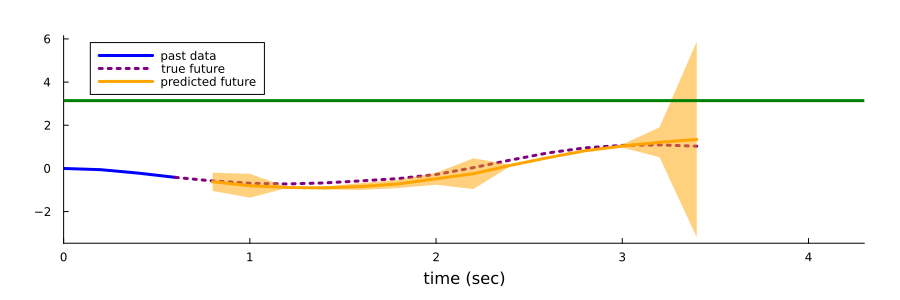

In [41]:
window = 5
k = 4
plot(tsteps[1:k], y_EFE[1:k], color="blue", xlims=(tsteps[1], tsteps[window+T+1]+0.5), label="past data", xlabel="time (sec)", size=(900,300))
plot!(tsteps[k:k+T], y_EFE[k:k+T], color="purple", label="true future", linestyle=:dot)
plot!(tsteps[k+1:k+T], mean.(py_EFE[k]), ribbon=var.(py_EFE[k]), label="predicted future", color="orange", legend=:topleft)

hline!([mean(goal)], color="green")

┌ Info: Saved animation to /home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/pendulum/figures/NARX-EFE-1Pendulum-planning.gif
└ @ Plots /home/wmkouw/.julia/packages/Plots/3BCH5/src/animation.jl:156


Plots.AnimatedGif("/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/pendulum/figures/NARX-EFE-1Pendulum-planning.gif")
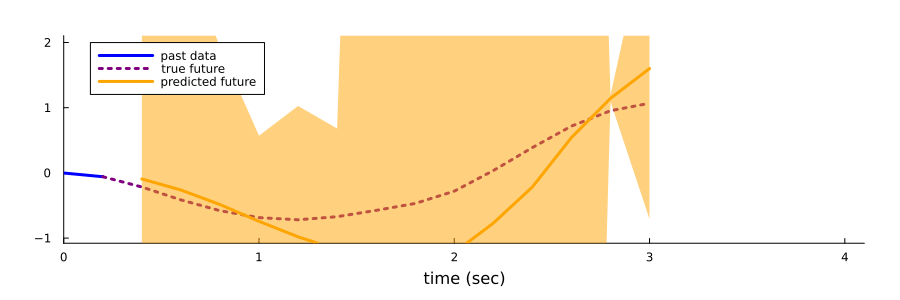

In [28]:
limsb = [minimum(y_EFE)*1.5, maximum(y_EFE)*1.5]

window = 4

anim = @animate for k in 2:2:(N-T-1)
    
    if k <= window
        plot(tsteps[1:k], y_EFE[1:k], color="blue", xlims=(tsteps[1], tsteps[window+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_EFE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], mean.(py_EFE[k]), ribbon=var.(py_EFE[k]), label="predicted future", color="orange", legend=:topleft)
        hline!([mean(goal)], color="green")
    else
        plot(tsteps[k-window:k], y_EFE[k-window:k], color="blue", xlims=(tsteps[k-window], tsteps[k+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_EFE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], mean.(py_EFE[k]), ribbon=var.(py_EFE[k]), label="prediction", color="orange", legend=:topleft)
        hline!([mean(goal)], color="green")
    end
    
end
gif(anim, "figures/NARX-EFE-1Pendulum-planning.gif", fps=3)

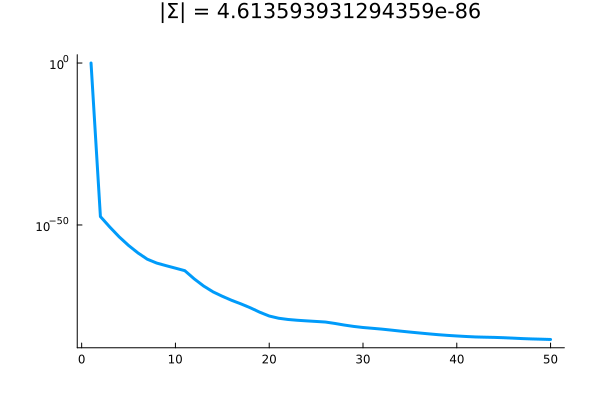

In [29]:
dSθ_EFE = [det(cov(pθ_EFE[k])) for k in 1:N]
final_dSθ_EFE = dSθ_EFE[end]
plot(dSθ_EFE, title="|Σ| = $final_dSθ_EFE", yscale=:log10)

### Mean Squared Error minimization

In [30]:
# Start system
pendulum = SPendulum(init_state = init_state, 
                     torque_lims = u_lims,
                     mass = sys_mass, 
                     length = sys_length, 
                     damping = sys_damping, 
                     mnoise_sd = sys_mnoise_sd, 
                     Δt=Δt)

# Track beliefs
py_MSE = [] 
pτ_MSE = [pτ0]
pθ_MSE = [pθ0]
goals = Any[false for t in 1:T]

# Start agent
agent = NARXAgent(qθ[end], qτ[end], 
                  goal_prior=goals, 
                  delay_in=Lu, 
                  delay_out=Ly, 
                  pol_degree=H,
                  thorizon=T,
                  control_prior=control_prior,
                  num_iters=num_iters)

# Preallocate
y_MSE = zeros(N)
u_MSE = zeros(N+T)
FE_MSE = zeros(num_iters, N)
policy = zeros(T)

@showprogress for k in 1:N
    
    # Act upon environment
    step!(pendulum, u_MSE[k])
    y_MSE[k] = pendulum.sensor

    """Perception"""
    
    # Update parameter beliefs
    NARXAgents.update!(agent, y_MSE[k], u_MSE[k])
    FE_MSE[:,k] = agent.free_energy
    push!(pθ_MSE, agent.qθ)
    push!(pτ_MSE, agent.qτ)

    """Action"""

    # Move goal closer
    update_goals!(goals, goal)
    agent.goals = goals
    
    # Optimal control
    policy = minimizeMSE(agent, goals, time_limit=tlimit, control_lims=u_lims)
    u_MSE[k+1:k+T] = policy
    
    # Store future predictions
    push!(py_MSE, predictions(agent, policy, time_horizon=T))
    
end

Progress:   4%|█▋                                       |  ETA: 0:02:15

Progress:   6%|██▌                                      |  ETA: 0:01:55

Progress:   8%|███▎                                     |  ETA: 0:02:43

Progress:  10%|████▏                                    |  ETA: 0:02:36

Progress:  12%|████▉                                    |  ETA: 0:02:14

Progress:  14%|█████▊                                   |  ETA: 0:01:59

Progress:  16%|██████▌                                  |  ETA: 0:01:51

Progress:  18%|███████▍                                 |  ETA: 0:01:52

Progress:  20%|████████▎                                |  ETA: 0:01:51

Progress:  22%|█████████                                |  ETA: 0:01:53

Progress:  24%|█████████▉                               |  ETA: 0:01:44

Progress:  26%|██████████▋                              |  ETA: 0:01:38

Progress:  28%|███████████▌                             |  ETA: 0:01:32

Progress:  30%|████████████▎                            |  ETA: 0:01:26

Progress:  32%|█████████████▏                           |  ETA: 0:01:26

Progress:  36%|██████████████▊                          |  ETA: 0:01:14

Progress:  38%|███████████████▋                         |  ETA: 0:01:11

Progress:  40%|████████████████▍                        |  ETA: 0:01:07

Progress:  42%|█████████████████▎                       |  ETA: 0:01:02

Progress:  44%|██████████████████                       |  ETA: 0:00:58

Progress:  46%|██████████████████▉                      |  ETA: 0:00:54

Progress:  48%|███████████████████▋                     |  ETA: 0:00:51

Progress:  50%|████████████████████▌                    |  ETA: 0:00:48

Progress:  52%|█████████████████████▍                   |  ETA: 0:00:44

Progress:  54%|██████████████████████▏                  |  ETA: 0:00:42

Progress:  56%|███████████████████████                  |  ETA: 0:00:39

Progress:  58%|███████████████████████▊                 |  ETA: 0:00:37

Progress:  60%|████████████████████████▋                |  ETA: 0:00:37

Progress:  62%|█████████████████████████▍               |  ETA: 0:00:37

Progress:  64%|██████████████████████████▎              |  ETA: 0:00:34

Progress:  66%|███████████████████████████              |  ETA: 0:00:32

Progress:  68%|███████████████████████████▉             |  ETA: 0:00:30

Progress:  70%|████████████████████████████▊            |  ETA: 0:00:28

Progress:  72%|█████████████████████████████▌           |  ETA: 0:00:26

Progress:  74%|██████████████████████████████▍          |  ETA: 0:00:23

Progress:  76%|███████████████████████████████▏         |  ETA: 0:00:21

Progress:  78%|████████████████████████████████         |  ETA: 0:00:19

Progress:  80%|████████████████████████████████▊        |  ETA: 0:00:17

Progress:  82%|█████████████████████████████████▋       |  ETA: 0:00:15

Progress:  84%|██████████████████████████████████▌      |  ETA: 0:00:13

Progress:  86%|███████████████████████████████████▎     |  ETA: 0:00:11

Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:10

Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:08

Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:06

Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:05

Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:03

Progress:  98%|████████████████████████████████████████▏|  ETA: 0:00:02

Progress: 100%|█████████████████████████████████████████| Time: 0:01:16


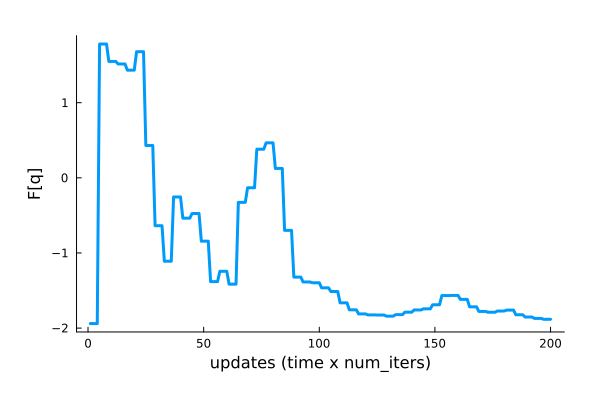

In [31]:
plot(FE_MSE[:], xlabel="updates (time x num_iters)", ylabel="F[q]")

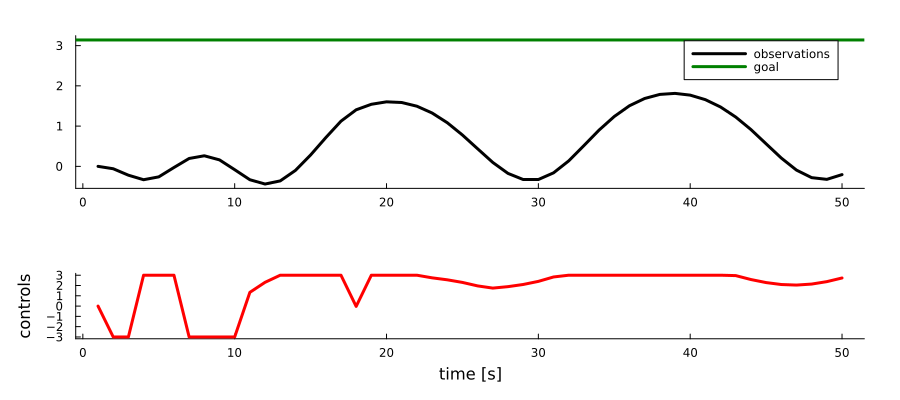

In [32]:
p1 = plot(y_MSE, color="black", label="observations")
hline!([mean(goal)], color="green", label="goal")
p4 = plot(u_MSE[1:end-T], color="red", ylabel="controls", xlabel="time [s]")

plot(p1,p4, layout=grid(2,1, heights=[.7, .3]), size=(900,400))

In [33]:
savefig("figures/NARX-MSE-1Pendulum-trial.png")

"/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/pendulum/figures/NARX-MSE-1Pendulum-trial.png"

┌ Info: Saved animation to /home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/pendulum/figures/NARX-MSE-1Pendulum-planning.gif
└ @ Plots /home/wmkouw/.julia/packages/Plots/3BCH5/src/animation.jl:156


Plots.AnimatedGif("/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/pendulum/figures/NARX-MSE-1Pendulum-planning.gif")
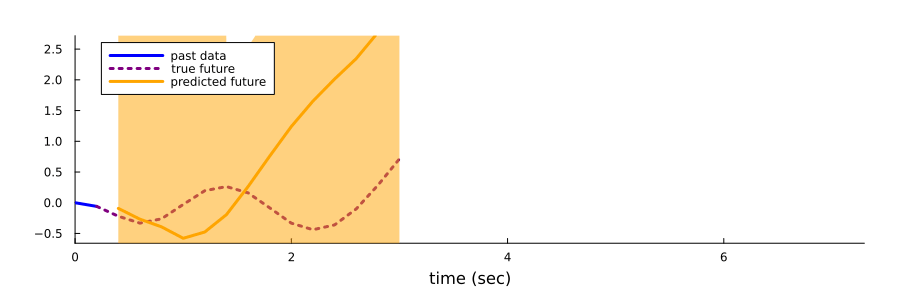

In [34]:
limsb = [minimum(y_MSE)*1.5, maximum(y_MSE)*1.5]

window = 20

anim = @animate for k in 2:2:(N-T-1)
    
    if k <= window
        plot(tsteps[1:k], y_MSE[1:k], color="blue", xlims=(tsteps[1], tsteps[window+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_MSE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], mean.(py_MSE[k]), ribbon=var.(py_MSE[k]), label="predicted future", color="orange", legend=:topleft)
        hline!([mean(goal)], color="green")
    else
        plot(tsteps[k-window:k], y_MSE[k-window:k], color="blue", xlims=(tsteps[k-window], tsteps[k+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_MSE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], mean.(py_MSE[k]), ribbon=var.(py_MSE[k]), label="prediction", color="orange", legend=:topleft)
        hline!([mean(goal)], color="green")
    end
    
end
gif(anim, "figures/NARX-MSE-1Pendulum-planning.gif", fps=10)

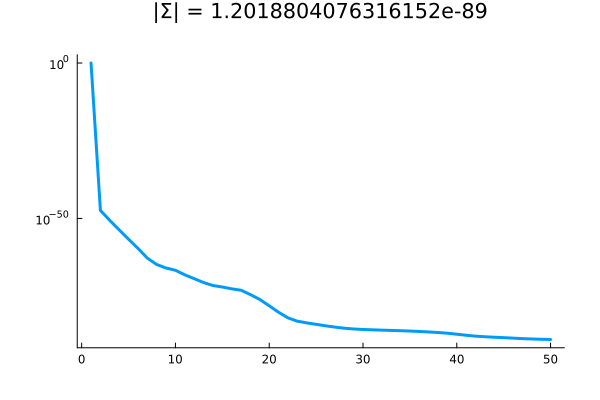

In [35]:
dSθ_MSE = [det(cov(pθ_MSE[k])) for k in 1:N]
final_dSθ_MSE = dSθ_MSE[end]
plot(dSθ_MSE, title="|Σ| = $final_dSθ_MSE", yscale=:log10)

### Comparisons

In [36]:
println("Final |Σ| MSE = $final_dSθ_MSE")
println("Final |Σ| EFE = $final_dSθ_EFE")

Final |Σ| MSE = 1.2018804076316152e-89
Final |Σ| EFE = 4.613593931294359e-86


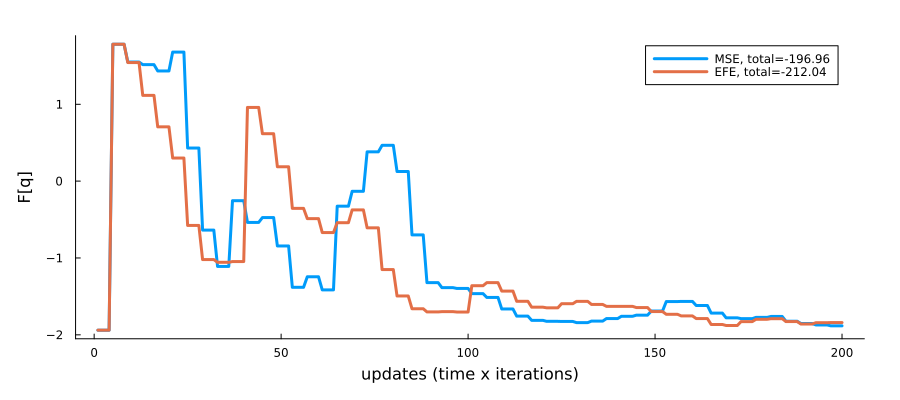

In [37]:
sF_MSE = round(sum(FE_MSE[:]), digits=2)
sF_EFE = round(sum(FE_EFE[:]), digits=2)

plot(xlabel="updates (time x iterations)", ylabel="F[q]", size=(900,400))
plot!(FE_MSE[:], label="MSE, total=$sF_MSE")
plot!(FE_EFE[:], label="EFE, total=$sF_EFE")

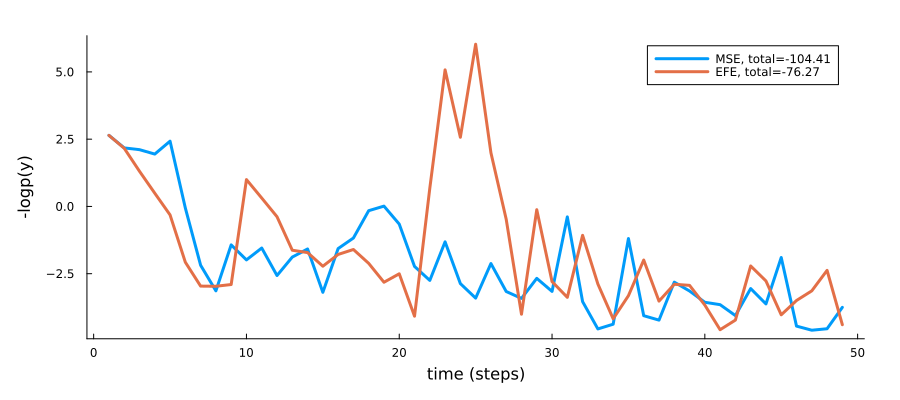

In [38]:
evidence_MSE = [-logpdf(py_MSE[k][1], y_MSE[k+1]) for k in 1:(N-1)]
evidence_EFE = [-logpdf(py_EFE[k][1], y_EFE[k+1]) for k in 1:(N-1)]

total_evidence_MSE = round(sum(evidence_MSE), digits=2)
total_evidence_EFE = round(sum(evidence_EFE), digits=2)

plot(xlabel="time (steps)", ylabel="-logp(y)", size=(900,400))
plot!(evidence_MSE, label="MSE, total=$total_evidence_MSE")
plot!(evidence_EFE, label="EFE, total=$total_evidence_EFE")

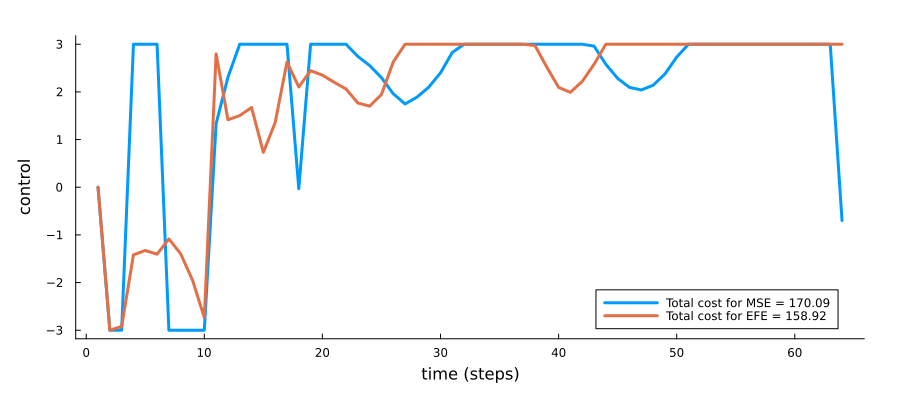

In [39]:
CC_MSE = round(sum(abs.(u_MSE)), digits=2)
CC_EFE = round(sum(abs.(u_EFE)), digits=2)

plot(xlabel="time (steps)", ylabel="control", size=(900,400))
plot!(u_MSE, label="Total cost for MSE = $CC_MSE")
plot!(u_EFE, label="Total cost for EFE = $CC_EFE")

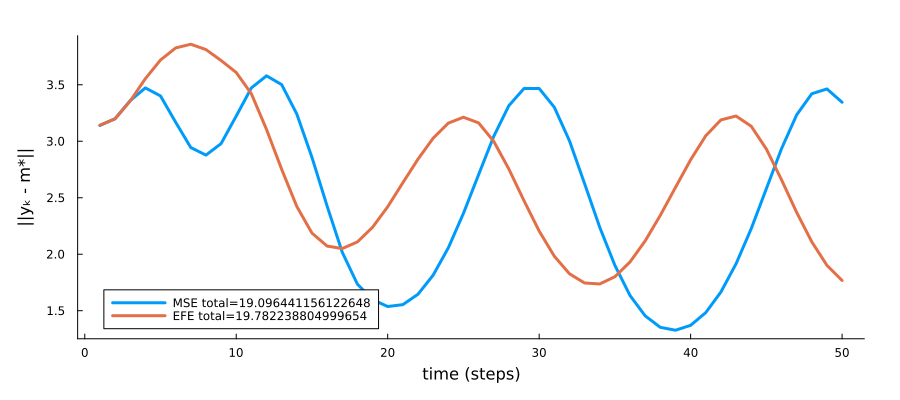

In [40]:
J_MSE = [norm(y_MSE[k] - mean(goal),2) for k in 1:N]
J_EFE = [norm(y_EFE[k] - mean(goal),2) for k in 1:N]

sJ_MSE = norm(y_MSE .- mean(goal),2)
sJ_EFE = norm(y_EFE .- mean(goal),2)

plot(xlabel="time (steps)", ylabel="||yₖ - m*||", size=(900,400))
plot!(J_MSE, label="MSE total=$sJ_MSE")
plot!(J_EFE, label="EFE total=$sJ_EFE")